# Time Series Forcasting with LSTM

import packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

2024-03-21 22:16:28.979084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 22:16:28.979133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 22:16:28.980020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 22:16:28.986305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 22:16:30.973615: W tensorflow/compiler/tf2

check the GPU usage.

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Preprocess the data

### Import data

In [3]:
data = pd.read_csv("fred_md.csv")
data = data[1:]
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5,5/1/1959,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5528,24.3936,23.1231,32.5925,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


### Deal with missing data

get the location of missing data

In [4]:
missing_values_list = []  
  
for col in data.columns:  
    for idx, value in enumerate(data[col]):  
        if pd.isnull(value):  
            missing_values_list.append((idx, col))  
  
# print(missing_values_list)  

check the missing data of UNRATE

In [5]:
unrate_missing = [(idx, col) for (idx, col) in missing_values_list if col == 'UNRATE'] 
print(unrate_missing)

[]


found that `UNRATE` doesn't have missingdata.

drop some features that frequently missing.

Infomation of these dropped features:

- New Orders for Consumer Goods

- New Orders for Nondefense Capital Goods

- FRED‐MD 2020‐04: Starting in this vintage, TWEXMMTH has been replaced with 
TWEXAFEGSMTHx. The previous series has been discontinued by the source. The new series has 
been constructed by splicing rebased TWEXMMTH and TWEXAFEGSMTH. 

- FRED‐MD 2016‐01: Starting in this vintage, the most recent value for the UMCSENTx is not 
shown due to the agreement with the source. Previously, this variable had a 6 month lag.

- FRED‐MD 2021‐12: Starting in this vintage, VXOCLSx has been replaced with VIXCLSx. The 
previous series has been discontinued by the source. 

In [6]:
columns_to_drop = ['ACOGNO', 'ANDENOx', 'TWEXAFEGSMTHx', 'UMCSENTx', 'VIXCLSx']
data = data.drop(columns=columns_to_drop)  

drop some date that have too much missing data.

In [7]:
rows_to_drop = list(range(1, 13)) + list(range(736, 782))  
data = data.drop(index=rows_to_drop)  

Check for missing data

In [8]:
missing_values_list = []  
  
for col in data.columns:  
    for idx, value in enumerate(data[col]):  
        if pd.isnull(value):  
            missing_values_list.append((idx, col))  
  
print(missing_values_list)  

[]


there is no missing data.

### Change data type

datetime

In [9]:
data.index = pd.to_datetime(data["sasdate"], format = "%m/%d/%Y")
data = data.drop(columns=['sasdate']) 
data[:5]

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,2695.694,2537.6,15.789,286930.9859,18763.67069,24.1712,25.3119,24.0877,34.0264,21.7598,...,15.421,63.672,18.410,10.466,2.22,2.57,2.13,7362.0,14063.0,75.4515
1960-02-01,2698.789,2539.9,15.858,291093.6977,18833.15808,23.9561,25.1684,24.0051,33.6388,21.4604,...,15.437,63.775,18.411,10.484,2.23,2.59,2.14,7396.0,14144.0,73.3363
1960-03-01,2703.859,2542.2,16.083,283044.8908,18812.41558,23.7410,25.0823,23.9775,33.6776,21.0362,...,15.446,63.589,18.445,10.490,2.24,2.69,2.14,7456.0,14239.0,71.5296
1960-04-01,2713.243,2551.4,16.331,285847.3937,19306.08721,23.5528,25.1398,24.0051,33.9101,21.0112,...,15.502,63.665,18.561,10.512,2.23,2.61,2.14,7582.0,14413.0,71.4718
1960-05-01,2719.777,2557.6,16.002,276978.5849,19017.76638,23.5259,25.2832,24.1704,34.1039,21.2108,...,15.518,63.658,18.553,10.540,2.24,2.64,2.14,7673.0,14559.0,71.6858


In [10]:
data = data.astype('float64')  

get the number of time and the number of features.

In [11]:
T, n = data.shape

In [12]:
T

723

### Plot the unrate

I encounter an error there. My kernel would crash when I excute these codes. 

updating all packages help to solve this error.

<Axes: xlabel='sasdate'>

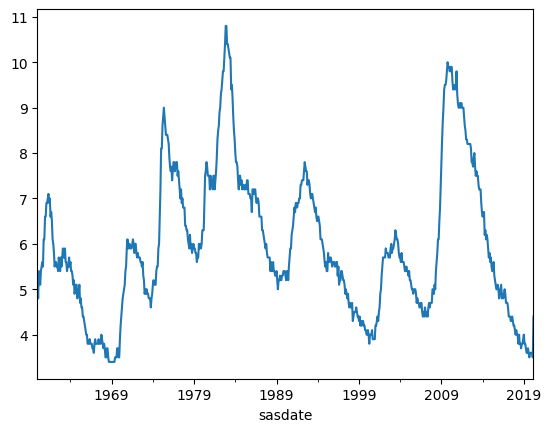

In [13]:
unrate = data["UNRATE"]
unrate.plot()

### Split the data

In [14]:
def data_to_X_y(data, window_size=12):
  data_as_np = data.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [a for a in data_as_np[i:i+window_size]]
    X.append(row)
    label = data.iloc[i+window_size]['UNRATE']
    y.append(label)
  return np.array(X), np.array(y)

set a WINDOW_SIZE.

In [15]:
WINDOW_SIZE = 120
X, y = data_to_X_y(data, WINDOW_SIZE)
X.shape, y.shape

((603, 120, 122), (603,))

In [16]:
T1 = int(T*0.6)
T2 = int(T*0.8)

X_train, y_train = X[:T1], y[:T1]
X_val, y_val = X[T1:T2], y[T1:T2]
X_test, y_test = X[T2:], y[T2:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((433, 120, 122), (433,), (145, 120, 122), (145,), (25, 120, 122), (25,))

In [17]:
433+145+25

603

### Normalize the data

In [18]:
def normalize(X, mean, std, i):
    X[:, :, i] = (X[:, :, i] - mean)/std

for i in range(n):
    mean = np.mean(X_train[:, :, i])
    std = np.std(X_train[:, :, i])
    normalize(X_train, mean, std, i)
    normalize(X_val, mean, std, i)
    normalize(X_test, mean, std, i)

## Train the model

### prepare the model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, n)))
model1.add(LSTM(128))
model1.add(Dense(64, 'sigmoid'))
model1.add(Dense(128, 'sigmoid'))
model1.add(Dense(512, 'sigmoid'))
model1.add(Dense(1024, 'sigmoid'))
model1.add(Dense(4096, 'sigmoid'))
model1.add(Dense(1, 'linear'))

model1.summary()

2024-03-21 22:16:36.599884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22277 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:82:00.0, compute capability: 8.6
2024-03-21 22:16:36.600534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22277 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6
2024-03-21 22:16:36.891594: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               128512    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 4096)              4198400   
                                                                 
 dense_5 (Dense)             (None, 1)                 4

In [20]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))

### Train the model

In [21]:
import time

In [22]:
epochs = 300
start_time = time.time()
history1 = model1.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=epochs, 
    callbacks=[cp1],
    verbose = 2, # one line of one epoch
)
end_time = time.time()
execution_time = end_time - start_time
print("execution time of fitting:", execution_time, "seconds")

Epoch 1/300


2024-03-21 22:16:41.660046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 22:16:42.339420: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b280bad50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 22:16:42.339463: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-21 22:16:42.339475: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-21 22:16:42.348651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711030602.450204 1028783 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 13s - loss: 11.7045 - val_loss: 5.9976 - 13s/epoch - 936ms/step
Epoch 2/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 2.9076 - val_loss: 5.2952 - 6s/epoch - 427ms/step
Epoch 3/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 2.1351 - val_loss: 3.7524 - 6s/epoch - 439ms/step
Epoch 4/300
14/14 - 0s - loss: 1.9614 - val_loss: 4.0413 - 199ms/epoch - 14ms/step
Epoch 5/300
14/14 - 0s - loss: 1.9610 - val_loss: 3.8762 - 201ms/epoch - 14ms/step
Epoch 6/300
14/14 - 0s - loss: 1.9231 - val_loss: 3.8225 - 192ms/epoch - 14ms/step
Epoch 7/300
14/14 - 0s - loss: 1.9437 - val_loss: 4.1254 - 198ms/epoch - 14ms/step
Epoch 8/300
14/14 - 0s - loss: 1.9434 - val_loss: 3.7892 - 198ms/epoch - 14ms/step
Epoch 9/300
14/14 - 0s - loss: 1.9316 - val_loss: 3.7754 - 200ms/epoch - 14ms/step
Epoch 10/300
14/14 - 0s - loss: 1.9187 - val_loss: 3.8954 - 198ms/epoch - 14ms/step
Epoch 11/300
14/14 - 0s - loss: 1.9014 - val_loss: 3.8884 - 199ms/epoch - 14ms/step
Epoch 12/300
14/14 - 0s - loss: 1.8939 - val_loss: 3.7615 - 197ms/epoch - 14ms/step
Epoch 13/300
14/14 - 0s - loss: 1.9325 - val_loss: 4.0178 - 194ms/epoch - 14ms/step
Epoch 14/300
14/14 - 0s - loss: 1.8784 - val_loss: 3.9951 - 192ms/epoch - 14ms/step
Epoch 15/300


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.2968 - val_loss: 3.6164 - 6s/epoch - 448ms/step
Epoch 31/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.2589 - val_loss: 3.5412 - 6s/epoch - 447ms/step
Epoch 32/300
14/14 - 0s - loss: 0.2094 - val_loss: 3.5574 - 198ms/epoch - 14ms/step
Epoch 33/300
14/14 - 0s - loss: 0.1839 - val_loss: 3.7191 - 196ms/epoch - 14ms/step
Epoch 34/300
14/14 - 0s - loss: 0.1596 - val_loss: 3.7424 - 193ms/epoch - 14ms/step
Epoch 35/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.1272 - val_loss: 3.5313 - 6s/epoch - 436ms/step
Epoch 36/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.0994 - val_loss: 3.5063 - 6s/epoch - 435ms/step
Epoch 37/300
14/14 - 0s - loss: 0.0709 - val_loss: 3.6582 - 197ms/epoch - 14ms/step
Epoch 38/300
14/14 - 0s - loss: 0.0590 - val_loss: 3.5649 - 195ms/epoch - 14ms/step
Epoch 39/300
14/14 - 0s - loss: 0.0445 - val_loss: 3.5448 - 199ms/epoch - 14ms/step
Epoch 40/300
14/14 - 0s - loss: 0.0359 - val_loss: 3.5158 - 198ms/epoch - 14ms/step
Epoch 41/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.0292 - val_loss: 3.4820 - 6s/epoch - 458ms/step
Epoch 42/300
14/14 - 0s - loss: 0.0249 - val_loss: 3.5213 - 198ms/epoch - 14ms/step
Epoch 43/300
14/14 - 0s - loss: 0.0209 - val_loss: 3.5444 - 195ms/epoch - 14ms/step
Epoch 44/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.0201 - val_loss: 3.4507 - 6s/epoch - 422ms/step
Epoch 45/300
14/14 - 0s - loss: 0.0178 - val_loss: 3.4732 - 200ms/epoch - 14ms/step
Epoch 46/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.0176 - val_loss: 3.4390 - 6s/epoch - 447ms/step
Epoch 47/300
14/14 - 0s - loss: 0.0171 - val_loss: 3.5006 - 201ms/epoch - 14ms/step
Epoch 48/300
14/14 - 0s - loss: 0.0171 - val_loss: 3.5113 - 197ms/epoch - 14ms/step
Epoch 49/300
INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


14/14 - 6s - loss: 0.0154 - val_loss: 3.3683 - 6s/epoch - 445ms/step
Epoch 50/300
14/14 - 0s - loss: 0.0166 - val_loss: 3.4667 - 202ms/epoch - 14ms/step
Epoch 51/300
14/14 - 0s - loss: 0.0152 - val_loss: 3.4318 - 198ms/epoch - 14ms/step
Epoch 52/300
14/14 - 0s - loss: 0.0142 - val_loss: 3.4188 - 198ms/epoch - 14ms/step
Epoch 53/300
14/14 - 0s - loss: 0.0140 - val_loss: 3.3947 - 196ms/epoch - 14ms/step
Epoch 54/300
14/14 - 0s - loss: 0.0131 - val_loss: 3.3917 - 193ms/epoch - 14ms/step
Epoch 55/300
14/14 - 0s - loss: 0.0124 - val_loss: 3.4732 - 191ms/epoch - 14ms/step
Epoch 56/300
14/14 - 0s - loss: 0.0126 - val_loss: 3.4458 - 195ms/epoch - 14ms/step
Epoch 57/300
14/14 - 0s - loss: 0.0117 - val_loss: 3.4175 - 196ms/epoch - 14ms/step
Epoch 58/300
14/14 - 0s - loss: 0.0121 - val_loss: 3.4616 - 193ms/epoch - 14ms/step
Epoch 59/300
14/14 - 0s - loss: 0.0117 - val_loss: 3.3837 - 190ms/epoch - 14ms/step
Epoch 60/300
14/14 - 0s - loss: 0.0117 - val_loss: 3.4098 - 193ms/epoch - 14ms/step
Epoch 6

In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

## Evaluate the performance

In [24]:
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

### training progress

In [26]:
def plot_training_progress(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylim([0, max(plt.ylim())])
    plt.ylabel('Loss')
    plt.title('training progress')

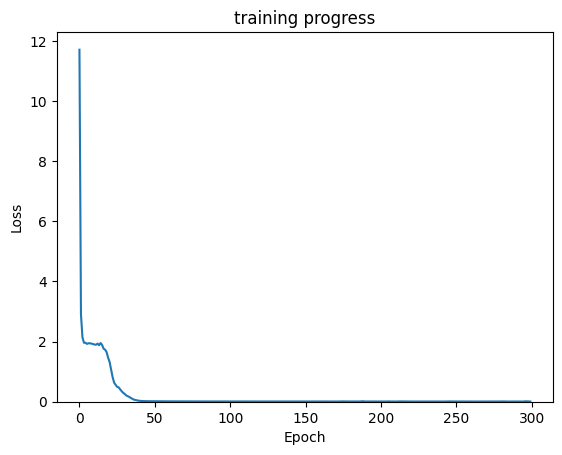

In [27]:
plot_training_progress(history1)

### predictions

In [28]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label = 'Predictions')
  plt.plot(df['Actuals'][start:end], label = 'Actuals')
  plt.legend()
  return df, mse(predictions, y)

14/14 [==============================] - 0s 5ms/step


(     Predictions  Actuals
 0       4.373008      3.9
 1       4.417722      4.2
 2       4.474583      4.4
 3       4.569232      4.6
 4       4.666598      4.8
 ..           ...      ...
 428     4.990376      5.0
 429     4.966197      5.0
 430     4.925805      5.0
 431     4.893492      4.9
 432     4.852756      4.7
 
 [433 rows x 2 columns],
 0.01589789018375523)

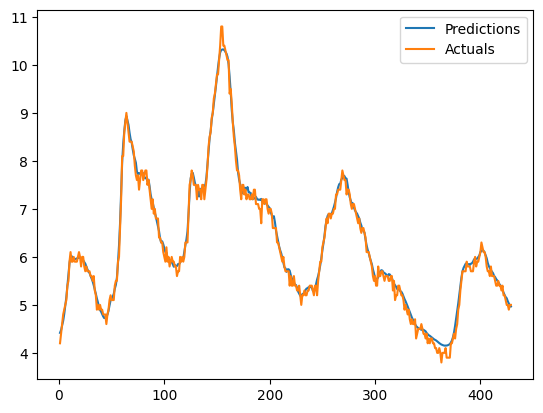

In [29]:
plot_predictions1(model1, X_train, y_train, 1, 430)

5/5 [==============================] - 0s 5ms/step


(     Predictions  Actuals
 0       4.819214      4.8
 1       4.805046      4.7
 2       4.786640      4.7
 3       4.778776      4.6
 4       4.782989      4.6
 ..           ...      ...
 140     6.022277      4.2
 141     6.019944      4.2
 142     6.020991      4.1
 143     6.021288      4.0
 144     6.028789      4.1
 
 [145 rows x 2 columns],
 3.368272649882544)

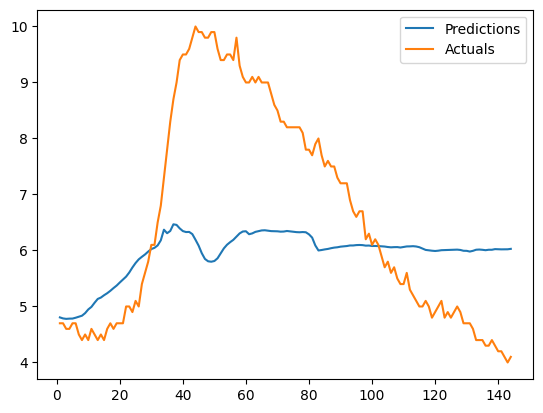

In [30]:
plot_predictions1(model1, X_val, y_val, 1, 145)

1/1 [==============================] - 0s 19ms/step


(    Predictions  Actuals
 0      6.057628      4.0
 1      6.094790      4.0
 2      6.103210      3.8
 3      6.100982      4.0
 4      6.088164      3.8
 5      6.070697      3.8
 6      6.037916      3.7
 7      6.004753      3.8
 8      6.009885      3.8
 9      5.982739      3.9
 10     5.950217      4.0
 11     5.931863      3.8
 12     5.914769      3.8
 13     5.888831      3.7
 14     5.870271      3.6
 15     5.852354      3.6
 16     5.840523      3.7
 17     5.825651      3.6
 18     5.822753      3.5
 19     5.814545      3.6
 20     5.825198      3.6
 21     5.833469      3.6
 22     5.858831      3.6
 23     5.871499      3.5
 24     5.867016      4.4,
 4.750902775587919)

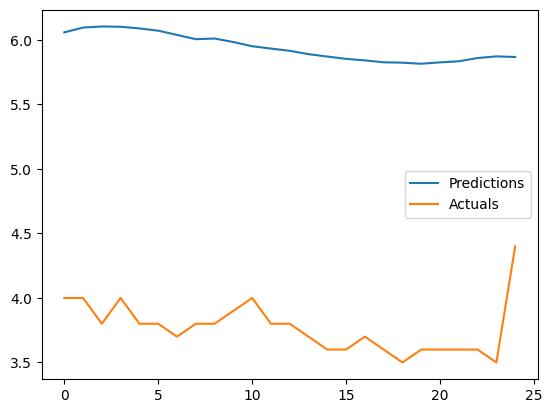

In [31]:
plot_predictions1(model1, X_test, y_test)